# Overview of Content:

### mlo_06-2_filter_oeni:

__Sections__:
- Main Module Import Section and Notebook Settings
- Initialize Custom Functions
- Read Notebook Variables
- Set Filter Settings
- Filter Response: ONI Unfiltered Data
- Filtering Time Domain Data
- Save Filtered Dataset


__Save Dataframes as Notebook Variables and as Text Files__:
- Save Filtered Dataset:
    - filtered_oeni

    
__Plot and Save Figures__:
- Filter Response: ONI Unfiltered Data:
    - filter_response_years_fft_oeni.pdf
    - filter_response_rad_fft_oeni.pdf
    - filter_response_bins_fft_oeni.pdf
- Filtering Time Domain Data:
    - filter_lowpass_filtered_oeni.pdf
    - filter_highpass_filtered_oeni.pdf
    - filter_butterworth_filtered_oeni.pdf

## Main Module Import Section and Notebook Settings

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.fftpack import fft
from scipy import signal
from scipy.signal import butter, lfilter
import math
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['lines.linewidth'] = 0.7
rcParams['figure.figsize'] = 9, 4.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config InlineBackend.figure_format = 'retina'
import matplotlib

myred = '#E24A33'
myblue = '#348ABD'

## Initialize Custom Functions

In [2]:
def butter_filter(b_lo, a_lo, b_hi, a_hi, data):
    """
    filter data with butterworth filter (high and low pass)
    """
    filtered_low = signal.filtfilt(b_lo, a_lo, data)
    filtered_high_low = signal.filtfilt(b_hi, a_hi, filtered_low)
    return filtered_high_low

In [3]:
def yr_sec(a=1):
    """
    convert years into seconds
    """
    return a * 60 * 60 * 24 * 365

In [4]:
def m_sec(m=1):
    """
    convert months into seconds
    """
    m_per_yr = 12 / m
    return yr_sec() / m_per_yr

In [5]:
def get_fs(t):
    """
    returns sampling rate in Hz from time period in s
    """
    return 1 / t

In [6]:
def get_res(bins, fs=get_fs(m_sec())):
    """
    calculate the resolution / time per bin in s
    """
    return 0.5 * fs / bins

In [7]:
def bin_yr(bin_peak, bins_tot):
    """
    calculates the corresponding year of a bin
    """
    if bin_peak <=0:
        bin_peak = 0.5
        
    return (bin_peak * get_res(bins_tot) * yr_sec())**-1

In [8]:
def bin_pirad(bin_peak, bins_tot):
    """
    calculates the corresponding pi rad per sample of a bin
    """
    rad_ax = np.linspace(0, 1, bins_tot)
    return rad_ax[bin_peak]

In [9]:
def pirad_yr(pi_rad, ax_rad):
    """
    converts a pi randian per sample value into the corresponding year.
    axis array with pi radians per sample is needed.
    """
    bin_ax = np.where(ax_rad <= pi_rad)
    closest_bin = np.max(bin_ax)
    return bin_yr(closest_bin, ax_rad.size)

In [10]:
def yr_pirad(yr, ax_yr):
    """
    converts a year into the corresponding pi radians per sample value.
    axis array with years is needed.
    """
    bin_ax = np.where(ax_yr >= yr)
    closest_bin = np.max(bin_ax)
    return bin_pirad(closest_bin, ax_yr.size)

## Read Notebook Variables

In [11]:
# read internal jupyter notebook variables

# stored via notebook: mlo_01_import.ipynb:
%store -r oeni

# stored via notebook: mlo_05_fft.ipynb:
%store -r fft_oeni

### Calculate Bins and Axis for Filter Preview

In [12]:
# get data from 1st fft
sig_fft = fft_oeni.mag  # magnitude 
sig_fft_norm = fft_oeni.mag_norm  # normalized magnitude
bins_fft = sig_fft.size  # number of bins

# get original time domain data
sig_time = oeni.oeni_notrend
bins_time = sig_time.size

In [13]:
# create array of pi radians per sample for axis
ax_fft_rad = np.linspace(0, 1, bins_fft)

# create array of bins for axis
ax_fft_bins = fft_oeni.index.values

# create array of years for axis
ax_fft_yr = fft_oeni.period_yr.values

## Set Filter Settings

##### Convert Limits for Filter from Years to Correspondig Pi Radians per Sample and Vice Versa

In [14]:
yr_pirad(1.2, ax_fft_yr)
yr_pirad(12, ax_fft_yr)

0.13888865998071678

0.013885569720393247

In [15]:
pirad_yr(0.13, ax_fft_rad)
pirad_yr(0.014, ax_fft_rad)

1.2820919175911252

11.911071849234393

In [16]:
lo_order = 18  # order of butterworth low pass filter
lo_lim = 0.13  # low pass limit (in pi radians per sample)

hi_order = 7  # order of butterworth high pass filter
hi_lim = 0.014  # high pass limit (in pi radians per sample)

### Get Parameters and Frequency Response of Butterworth Filter

In [17]:
# for low pass with set filter settings
b_lo, a_lo = signal.butter(lo_order, lo_lim, btype='low')
_, h_lo = signal.freqz(b_lo, a_lo, bins_fft)
h_lo = np.abs(h_lo)

# for high pass with set filter settings
b_hi, a_hi = signal.butter(hi_order, hi_lim, btype='high')
_, h_hi = signal.freqz(b_hi, a_hi, bins_fft)
h_hi = np.abs(h_hi)

## Filter Response: ONI Unfiltered Data

##### ONI Unfiltered FFT Data:

In [18]:
fft_oeni.head()
fft_oeni.tail()

,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
0,0.000000e+00,0,121350,40450.000000,14.226586,0.138747,0.000117,0.138747,0.000000,0.00000
1,1.568813e-12,1,121350,20225.000000,14.226587,0.138747,0.000117,0.138747,-0.011592,-0.00369
2,3.137626e-12,2,121350,10112.500000,14.226592,0.138747,0.000117,0.138747,-0.023184,-0.00738
3,4.706439e-12,3,121350,6741.666667,14.226599,0.138747,0.000117,0.138747,-0.034777,-0.01107
4,6.275252e-12,4,121350,5056.250000,14.226608,0.138747,0.000117,0.138747,-0.046370,-0.01476


,freq,bin,bins_total,period_yr,mag,mag_norm,amp,amp_norm,pha,pha_norm
bin,,,,,,,,,,
121345,1.903676e-07,121345,121350,0.166674,0.073668,0.000718,6.070697e-07,0.000718,0.049668,0.015810
121346,1.903692e-07,121346,121350,0.166672,0.073654,0.000718,6.069523e-07,0.000718,0.039738,0.012649
121347,1.903707e-07,121347,121350,0.166671,0.073643,0.000718,6.068611e-07,0.000718,0.029805,0.009487
121348,1.903723e-07,121348,121350,0.166669,0.073635,0.000718,6.067958e-07,0.000718,0.019871,0.006325
121349,1.903739e-07,121349,121350,0.166668,0.073630,0.000718,6.067567e-07,0.000718,0.009936,0.003163


##### ONI Unfiltered Data vs. Frequency Periods in Years

<IPython.core.display.Javascript object>


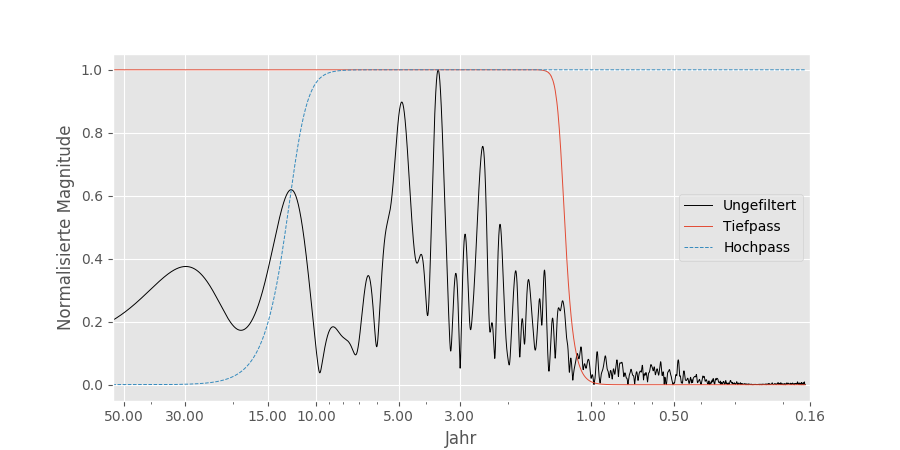

(55, 0.16)

In [19]:
rcParams['figure.figsize'] = 9, 4.5

x_start = 55
x_stop = 0.16
x_years = [0.16, 0.5, 1, 3, 5, 10, 15, 30, 50]

fig, ax = plt.subplots()
ax.plot(fft_oeni.period_yr.values, sig_fft_norm, label='Ungefiltert', color='k')
ax.plot(fft_oeni.period_yr.values, h_lo, label='Tiefpass')
ax.plot(fft_oeni.period_yr.values, h_hi, '--', label='Hochpass')
ax.set_ylabel('Normalisierte Magnitude')

ax.set_xlabel('Jahr')
ax.set_xscale('log')
ax.set_xlim(x_start, x_stop)
ax.set_xticks(x_years)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend()
plt.savefig('plots/filter_response_years_fft_oeni.pdf')

##### ONI Unfiltered Data vs. Pi Radians per Sample

<IPython.core.display.Javascript object>


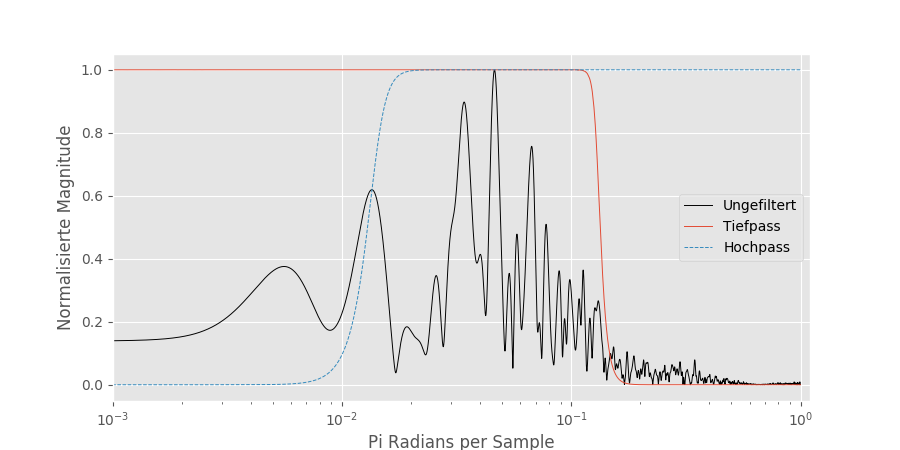

(0.001, 1.1)

In [20]:
fig = plt.figure()
plt.plot(ax_fft_rad, sig_fft_norm, label='Ungefiltert', color='k')
plt.plot(ax_fft_rad, h_lo,  label='Tiefpass')
plt.plot(ax_fft_rad, h_hi, '--', label='Hochpass')
plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Pi Radians per Sample')
plt.xscale('log')
plt.xlim(0.001, 1.1)
plt.legend()
plt.savefig('plots/filter_response_rad_fft_oeni.pdf')

##### ONI Unfiltered Data vs. Frequency Bins

<IPython.core.display.Javascript object>


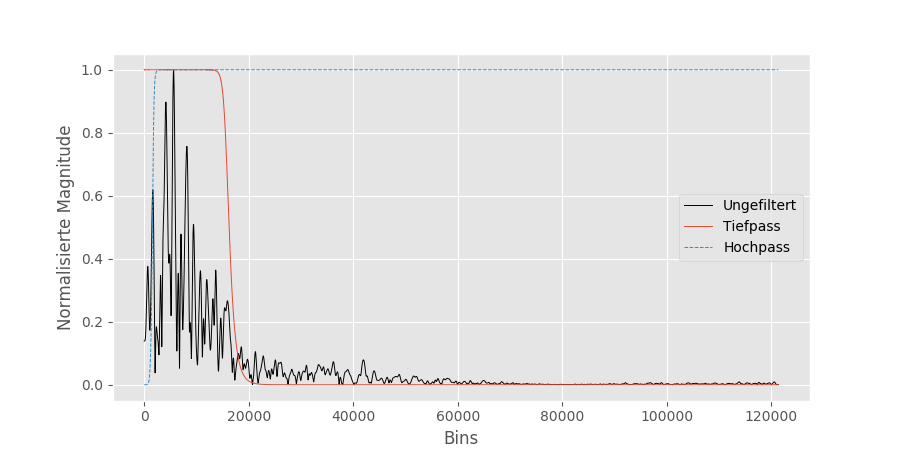

In [21]:
fig = plt.figure()
plt.plot(ax_fft_bins, sig_fft_norm, label='Ungefiltert', color='k')
plt.plot(ax_fft_bins, h_lo, label='Tiefpass')
plt.plot(ax_fft_bins, h_hi, '--', label='Hochpass')
plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Bins')
plt.legend()
plt.savefig('plots/filter_response_bins_fft_oeni.pdf')

# Filtering Time Domain Data

### Filtering with Butterworth Filter
Settings from above Section **_Set Filter Settings_**

In [22]:
filtered = butter_filter(b_lo, a_lo, b_hi, a_hi, sig_time.values)  # high and low pass
lowpass = signal.filtfilt(b_lo, a_lo, sig_time.values)  # only low pass
highpass = signal.filtfilt(b_hi, a_hi, sig_time.values)  # only high pass

Number of Samples:

In [23]:
filtered.size  # number of samples

809

### Filtered Time Domain Signal: Low Pass only on Mauna-Loa Data:
Let passes frequency below limit frequency -> corresponding year and longer time periods

<IPython.core.display.Javascript object>


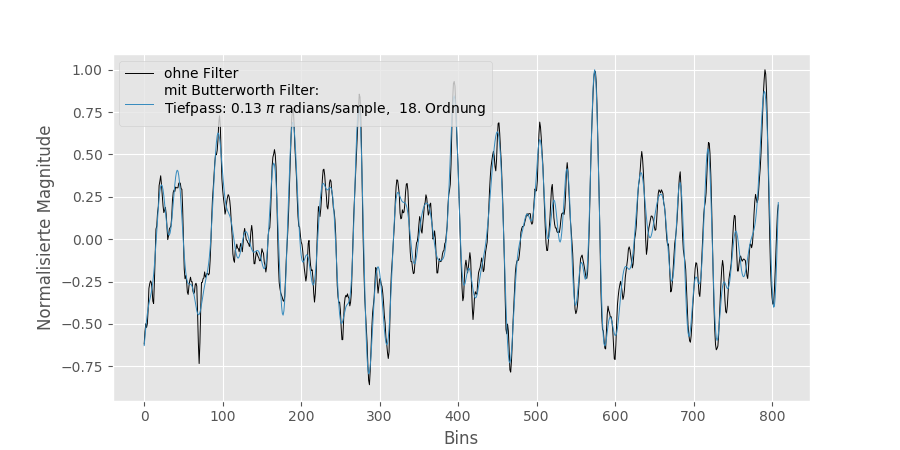

In [24]:
fig = plt.figure()

label_filtered = 'mit Butterworth Filter:\nTiefpass: ' \
    + str(lo_lim) + ' $ \pi$ radians/sample,  ' + str(lo_order) + '. Ordnung'
label_unfiltered = 'ohne Filter'

plt.plot(sig_time.values/np.max(np.abs(sig_time.values)), label=label_unfiltered, color='k')
plt.plot(lowpass/np.max(np.abs(lowpass)), label=label_filtered, color=myblue)
plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Bins')
plt.legend()
plt.savefig('plots/filter_lowpass_filtered_oeni.pdf')

### Filtered Time Domain Signal: High Pass only on Mauna-Loa Data:
Let passes frequency atop limit frequency -> corresponding year and shorter time periods

<IPython.core.display.Javascript object>


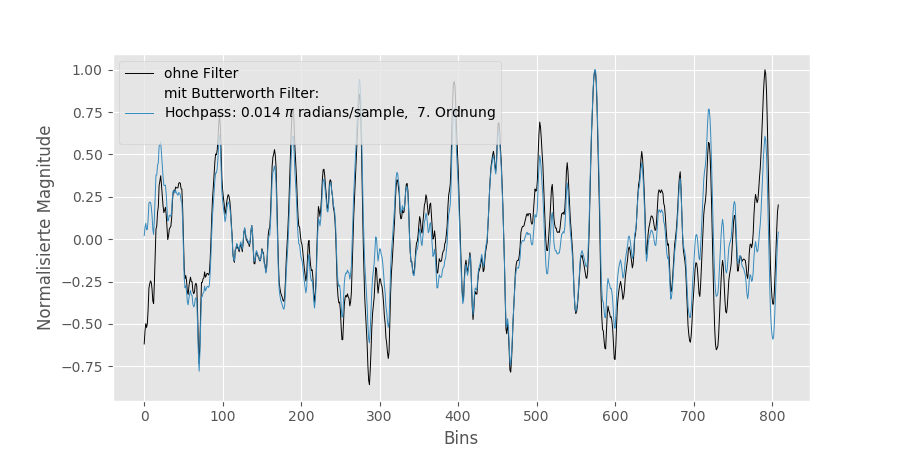

In [25]:
fig = plt.figure()

label_filtered = 'mit Butterworth Filter:\nHochpass: ' \
    + str(hi_lim) + ' $ \pi$ radians/sample,  ' + str(hi_order) + '. Ordnung\n'
label_unfiltered = 'ohne Filter'

plt.plot(sig_time.values/np.max(np.abs(sig_time.values)), label=label_unfiltered, color='k')
plt.plot(highpass/np.max(np.abs(highpass)), label=label_filtered, color=myblue)
plt.ylabel('Normalisierte Magnitude')
plt.xlabel('Bins')
plt.legend()
plt.savefig('plots/filter_highpass_filtered_oeni.pdf')

### Filtered Time Domain Signal: High and Low on Mauna-Loa Data:
Let passes frequency between high and low limit frequency

<IPython.core.display.Javascript object>


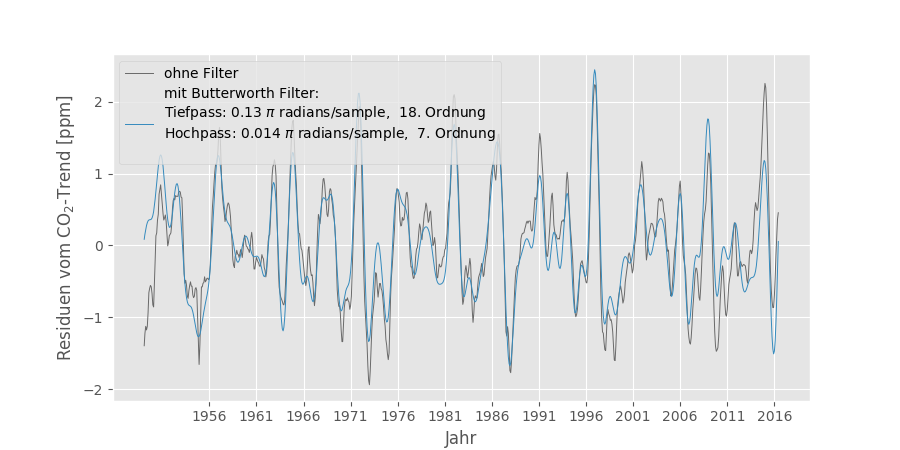

([<matplotlib.axis.XTick at 0x117e260f0>,
 <a list of 13 Text xticklabel objects>)

In [26]:
rcParams['figure.figsize'] = 9, 4.5

fig = plt.figure()
label_filtered = 'mit Butterworth Filter:\nTiefpass: ' \
    + str(lo_lim) + ' $ \pi$ radians/sample,  ' + str(lo_order) + '. Ordnung\n' \
    + 'Hochpass: ' + str(hi_lim) + ' $ \pi$ radians/sample,  ' + str(hi_order) + '. Ordnung\n'
label_unfiltered = 'ohne Filter'

plt.plot(sig_time.index.values, sig_time.values, label=label_unfiltered, color='dimgrey')
plt.plot(sig_time.index.values, filtered, label=label_filtered, color=myblue)
plt.xticks(pd.date_range(start='1956', end='2021', freq='5A'))

plt.ylabel('Residuen vom CO$_2$-Trend [ppm]')
plt.xlabel('Jahr')
plt.legend()
plt.savefig('plots/filter_butterworth_filtered_oeni.pdf')

## Save Filtered Dataset

In [27]:
filtered_oeni = pd.DataFrame()
filtered_oeni['oeni_unfiltered'] = sig_time
filtered_oeni['oeni_filtered'] = filtered
filtered_oeni['oeni_lowpass'] = lowpass
filtered_oeni['oeni_highpass'] = highpass

%store filtered_oeni
%store filtered_oeni >data_results/filtered_oeni.txt

filtered_oeni.head()
filtered_oeni.tail()

Stored 'filtered_oeni' (DataFrame)
Writing 'filtered_oeni' (DataFrame) to file 'data_results/filtered_oeni.txt'.


,oeni_unfiltered,oeni_filtered,oeni_lowpass,oeni_highpass
1950-01-31,-1.395703,0.085444,-1.395784,0.050709
1950-02-28,-1.225713,0.156929,-1.277110,0.175780
1950-03-31,-1.125724,0.222312,-1.164724,0.230992
1950-04-30,-1.175734,0.276620,-1.063630,0.136376
1950-05-31,-1.125745,0.316766,-0.976946,0.141963


,oeni_unfiltered,oeni_filtered,oeni_lowpass,oeni_highpass
2017-01-31,-0.444230,-1.323775,-0.763979,-0.945789
2017-02-28,-0.144240,-1.077253,-0.548722,-0.610650
2017-03-31,0.125749,-0.748203,-0.252814,-0.303839
2017-04-30,0.365739,-0.360768,0.099744,-0.025542
2017-05-31,0.455728,0.056042,0.480110,0.104027
